# MT3DMS Example Problems

The purpose of this notebook is to recreate the example problems that are described in the 1999 MT3DMS report.

There are 10 example problems:
1. One-Dimensional Transport in a Uniform Flow Field
2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
3. Two-Dimensional Transport in a Uniform Flow Field
4. Two-Dimensional Transport in a Diagonal Flow Field
5. Two-Dimensional Transport in a Radial Flow Field
6. Concentration at an Injection/Extraction Well
7. Three-Dimensional Transport in a Uniform Flow Field
8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer
9. Two-Dimensional Application Example
10. Three-Dimensional Field Case Study

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy
from flopy.utils.util_array import read1d

matplotlib.rcParams['figure.figsize'] = (8, 8)

exe_name_mf = 'mf2005'
exe_name_mt = 'mt3dms'
datadir = os.path.join('..', 'data', 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', 'data')

## Example 1. One-Dimensional Transport in a Uniform Flow Field

This example has 4 cases:
* Case 1a: Advection only
* Case 1b: Advection and dispersion
* Case 1c: Advection, dispersion, and sorption
* Case 1d: Advection, dispersion, sorption, and decay

In [2]:
def p01(dirname, al, retardation, lambda1, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 1
    ncol = 101
    delr = 10
    delc = 1
    delv = 1
    Lx = (ncol - 1) * delr
    v = 0.24
    prsity = 0.25
    q = v * prsity

    perlen = 2000.
    hk = 1.
    laytyp = 0
    rhob = 0.25
    kd = (retardation - 1.) * prsity / rhob

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[0, 0, 0] = -1
    ibound[0, 0, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    strt[0, 0, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    c0 = 1.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
    icbund[0, 0, 0] = -1
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    sconc[0, 0, 0] = c0
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc)
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 4
    npmin = 0
    npmax = 8
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    rct = flopy.mt3d.Mt3dRct(mt, isothm=1, ireact=1, igetsc=0, rhob=rhob, sp1=kd, 
                             rc1=lambda1, rc2=lambda1)
    ssm = flopy.mt3d.Mt3dSsm(mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

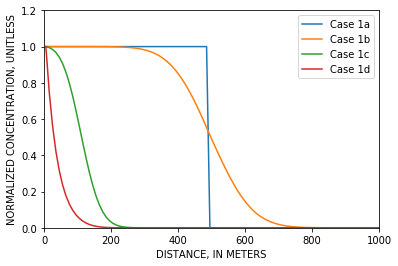

In [3]:
mf, mt, conc, cvt, mvt = p01('case1a', 0, 1, 0, 1)
x = mf.dis.sr.xcenter
y = conc[0, 0, 0, :]
plt.plot(x, y, label='Case 1a')

mf, mt, conc, cvt, mvt = p01('case1b', 10, 1, 0, 1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='Case 1b')

mf, mt, conc, cvt, mvt = p01('case1c', 10, 5, 0, 2)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='Case 1c')

mf, mt, conc, cvt, mvt = p01('case1d', 10, 5, 0.002, 2)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='Case 1d')

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel('DISTANCE, IN METERS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

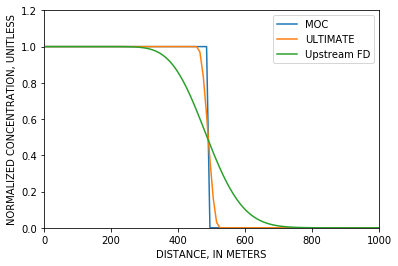

In [4]:
mf, mt, conc, cvt, mvt = p01('case1e', 0, 1, 0, 1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='MOC')

mf, mt, conc, cvt, mvt = p01('case1f', 0, 1, 0, -1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='ULTIMATE')

mf, mt, conc, cvt, mvt = p01('case1g', 0, 1, 0, 0)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='Upstream FD')

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel('DISTANCE, IN METERS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

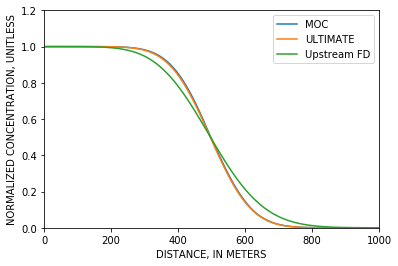

In [5]:
mf, mt, conc, cvt, mvt = p01('case1e', 10, 1, 0, 1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='MOC')

mf, mt, conc, cvt, mvt = p01('case1f', 10, 1, 0, -1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='ULTIMATE')

mf, mt, conc, cvt, mvt = p01('case1g', 10, 1, 0, 0)
y = conc[0, 0, 0, :]
plt.plot(x, y, label='Upstream FD')

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel('DISTANCE, IN METERS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

## Example 2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption

In [6]:
def p02(dirname, isothm, sp1, sp2, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 1
    ncol = 101
    delr = .16
    delc = 1
    delv = 1
    Lx = (ncol - 1) * delr
    v = 0.1
    prsity = 0.37
    q = v * prsity

    perlen_mf = 1.
    perlen_mt = [160, 1320]
    hk = 1.
    laytyp = 0
    rhob = 1.587

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[0, 0, 0] = -1
    ibound[0, 0, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    strt[0, 0, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0,
                             nper=2, perlen=perlen_mt, obs=[(0, 0, 50)])
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 4
    npmin = 0
    npmax = 8
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    al = 1.
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, ireact=0, igetsc=0, rhob=rhob, 
                             sp1=sp1, sp2=sp2)
    c0 = 0.05
    spd = {0:[0, 0, 0, c0, 1], 1:[0, 0, 0, 0., 1]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt    

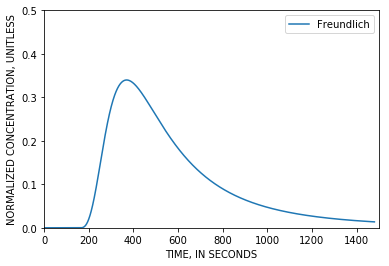

In [7]:
mf, mt, conc, cvt, mvt = p02('freundlich', 2, 0.3, 0.7, -1)
x = cvt['time']
y = cvt['(1, 1, 51)'] / .05
plt.plot(x, y, label='Freundlich')
plt.xlim(0, 1500)
plt.ylim(0, 0.5)
plt.xlabel('TIME, IN SECONDS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

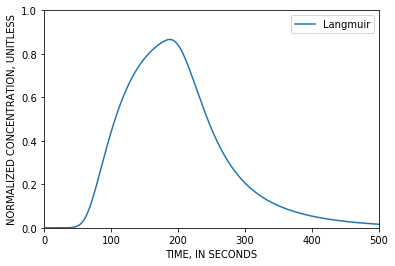

In [8]:
mf, mt, conc, cvt, mvt = p02('langmuir', 3, 100., 0.003, -1)
x = cvt['time']
y = cvt['(1, 1, 51)'] / .05
plt.plot(x, y, label='Langmuir')
plt.xlim(0, 500)
plt.ylim(0, 1.0)
plt.xlabel('TIME, IN SECONDS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

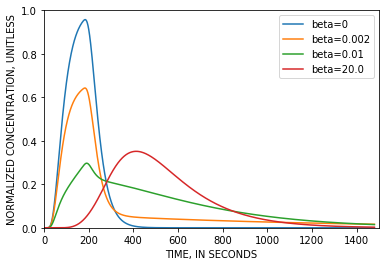

In [9]:
for beta in [0, 2.e-3, 1.e-2, 20.]:
    lbl = 'beta={}'.format(beta)
    mf, mt, conc, cvt, mvt = p02('nonequilibrium', 4, 0.933, beta, -1)
    x = cvt['time']
    y = cvt['(1, 1, 51)'] / .05
    plt.plot(x, y, label=lbl)
plt.xlim(0, 1500)
plt.ylim(0, 1.0)
plt.xlabel('TIME, IN SECONDS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

## Example 3. Two-Dimensional Transport in a Uniform Flow Field

In [10]:
def p03(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 46
    delr = 10
    delc = 10
    delv = 10
    Lx = (ncol - 1) * delr
    v = 1. / 3.
    prsity = 0.3
    q = v * prsity
    al = 10.
    trpt = .3
    q0 = 1.
    c0 = 1000.

    perlen_mf = 365.
    perlen_mt = 365.
    hk = 1.
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[0, :, 0] = -1
    ibound[0, :, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    strt[0, :, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 15, 15, q0]])
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0:[0, 15, 15, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt    

Text(0.5,1,'HMOC')

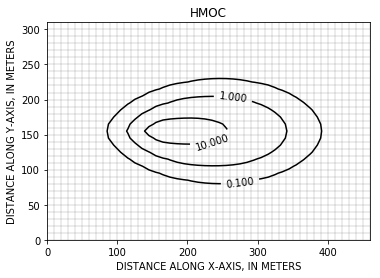

In [11]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p03('p03', 3)
conc = conc[0, :, :, :]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(conc, levels=[0.1, 1., 10., 50.], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('HMOC')

Text(0.5,1,'ULTIMATE')

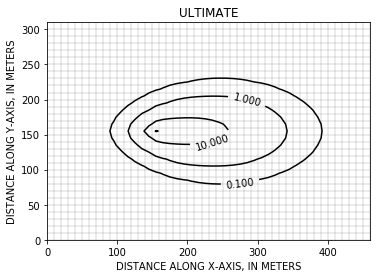

In [12]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p03('p03', -1)
conc = conc[0, :, :, :]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(conc, levels=[0.1, 1., 10., 50.], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('ULTIMATE')

## Example 4. Two-Dimensional Transport in a Diagonal Flow Field

In [13]:
def p04(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 100
    ncol = 100
    delr = 10
    delc = 10
    delv = 1
    Lx = (ncol - 1) * delr
    Ly = (nrow - 1) * delc
    Ls = np.sqrt(Lx ** 2 + Ly ** 2)
    v = 1.
    prsity = 0.14
    q = v * prsity
    al = 2.
    trpt = .1
    q0 = 0.01
    c0 = 1000.

    perlen_mf = 1000.
    perlen_mt = 1000.
    hk = 1.
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int) * -1
    ibound[:, 1:nrow - 1, 1:ncol-1] = 1

    # set strt as a linear gradient at a 45 degree angle
    h1 = q * Ls
    x = dis.sr.xcentergrid
    y = dis.sr.ycentergrid
    a = -1
    b = -1
    c = 1
    d = abs(a*x + b*y + c) / np.sqrt(2)
    strt = h1 - d / Ls * h1

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 79, 20, q0]])
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0:[0, 79, 20, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

Text(0.5,1,'MOC')

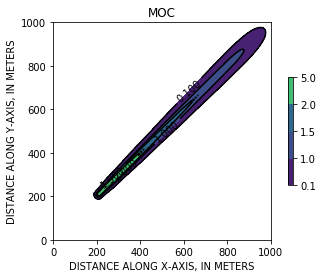

In [14]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p04('p04', 1)
sr = mf.dis.sr
conc = conc[0, :, :, :]
levels = [0.1, 1., 1.5, 2., 5.0]
mm = flopy.plot.ModelMap(model=mf)
cf = plt.contourf(sr.xcentergrid, sr.ycentergrid, conc[0], levels=levels)
plt.colorbar(cf, shrink=0.5)
cs = mm.contour_array(conc, levels=levels, colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('MOC')

Text(0.5,1,'Upstream FD')

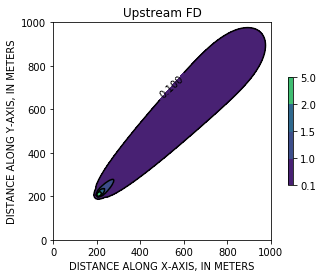

In [15]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p04('p04', 0)
sr = mf.dis.sr
conc = conc[0, :, :, :]
levels = [0.1, 1., 1.5, 2., 5.0]
mm = flopy.plot.ModelMap(model=mf)
cf = plt.contourf(sr.xcentergrid, sr.ycentergrid, conc[0], levels=levels)
plt.colorbar(cf, shrink=0.5)
cs = mm.contour_array(conc, levels=levels, colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('Upstream FD')

Text(0.5,1,'ULTIMATE')

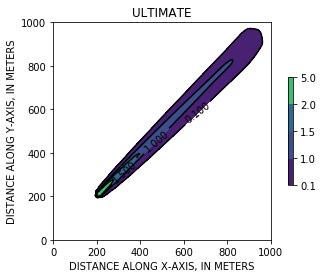

In [16]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p04('p04', -1)
sr = mf.dis.sr
conc = conc[0, :, :, :]
levels = [0.1, 1., 1.5, 2., 5.0]
mm = flopy.plot.ModelMap(model=mf)
cf = plt.contourf(sr.xcentergrid, sr.ycentergrid, conc[0], levels=levels)
plt.colorbar(cf, shrink=0.5)
cs = mm.contour_array(conc, levels=levels, colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('ULTIMATE')

## Example 5. Two-Dimensional Transport in a Radial Flow Field

In [17]:
def theis_u(r, S, T, t):
    return r**2 * S / 4. / T / t

def theis_drawdown(t, S, T, Q, r):
    import scipy.special
    u = theis_u(r, S, T, t)
    s_theis = Q / 2. / np.pi / T * scipy.special.exp1(u)
    return s_theis

def p05(dirname, mixelm, dt0, ttsmult):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 31
    delr = 10
    delc = 10
    delv = 1
    prsity = 0.30
    al = 10.
    trpt = 1.
    q0 = 100.
    c0 = 1.

    perlen_mf = 27.
    perlen_mt = 27.
    hk = 1.
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, 
                               exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int) * -1
    ibound[:, 1:nrow - 1, 1:ncol-1] = 1

    # set strt from theis equation
    x = dis.sr.xcentergrid
    y = dis.sr.ycentergrid
    r = np.sqrt((155 - x) ** 2 + (155 - y) ** 2)
    strt = theis_drawdown(27., 0.0001, 1., q0, r)
    strt[15, 15] = strt[15, 14]

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 15, 15, q0]])
    sip = flopy.modflow.ModflowSip(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0, 
                             dt0=dt0, ttsmult=ttsmult)
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0:[0, 15, 15, c0, -1]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt    

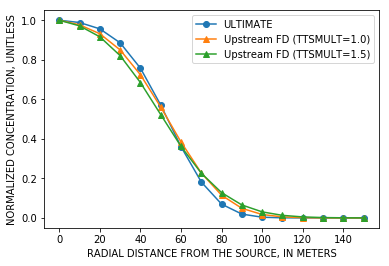

In [18]:
mf, mt, conc, cvt, mvt  = p05('p05', -1, 0.3, 1.0)
sr = mf.dis.sr
conc = conc[0, 0, :, :]
x = sr.xcentergrid[15, 15:] - sr.xcentergrid[15, 15]
y = conc[15, 15:]
plt.plot(x, y, label='ULTIMATE', marker='o')

mf, mt, conc, cvt, mvt = p05('p05', 0, 0.3, 1.0)
conc = conc[0, 0, :, :]
x = sr.xcentergrid[15, 15:] - sr.xcentergrid[15, 15]
y = conc[15, 15:]
plt.plot(x, y, label='Upstream FD (TTSMULT=1.0)', marker='^')

mf, mt, conc, cvt, mvt = p05('p05', 0, 0.3, 1.5)
conc = conc[0, 0, :, :]
x = sr.xcentergrid[15, 15:] - sr.xcentergrid[15, 15]
y = conc[15, 15:]
plt.plot(x, y, label='Upstream FD (TTSMULT=1.5)', marker='^')

plt.xlabel('RADIAL DISTANCE FROM THE SOURCE, IN METERS')
plt.ylabel('NORMALIZED CONCENTRATION, UNITLESS')
plt.legend()

Text(0.5,1,'ULTIMATE')

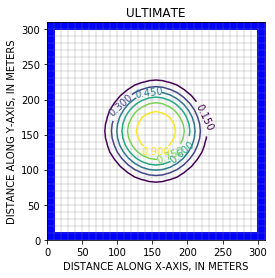

In [19]:
ax = plt.subplot(1, 1, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p05('p05', -1, 0.3, 1.0)
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
mm.plot_ibound()
cs = mm.contour_array(conc[0])
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('ULTIMATE')

## Example 6. Concentration at an Injection/Extraction Well

In [20]:
def p06(dirname, mixelm, dt0):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 31
    delr = 900
    delc = 900
    delv = 20
    prsity = 0.30
    al = 100.
    trpt = 1.
    q0 = 86400.
    c0 = 100.

    perlen_mf = [912.5, 2737.5]
    perlen_mt = perlen_mf
    hk = 0.005 * 86400
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, 
                               exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   nper=2, perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int) * -1
    ibound[:, 1:nrow - 1, 1:ncol-1] = 1

    # set strt from theis equation
    x = dis.sr.xcentergrid
    y = dis.sr.ycentergrid
    r = np.sqrt((155 - x) ** 2 + (155 - y) ** 2)
    strt = theis_drawdown(912.5, 0.0001, hk * delv, q0, r)
    strt[15, 15] = strt[15, 14]
    #strt = 0.

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    welspd = {0: [[0, 15, 15, q0]], 1: [[0, 15, 15, -q0]]}
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    sip = flopy.modflow.ModflowSip(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0, 
                             nper=2, perlen=perlen_mt, dt0=dt0, 
                             obs=[(0, 15, 15)])
    dceps = 1.e-5
    nplane = 1
    npl = 16
    nph = 16
    npmin = 4
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0:[0, 15, 15, c0, 2], 1:[0, 15, 15, 0., 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt  

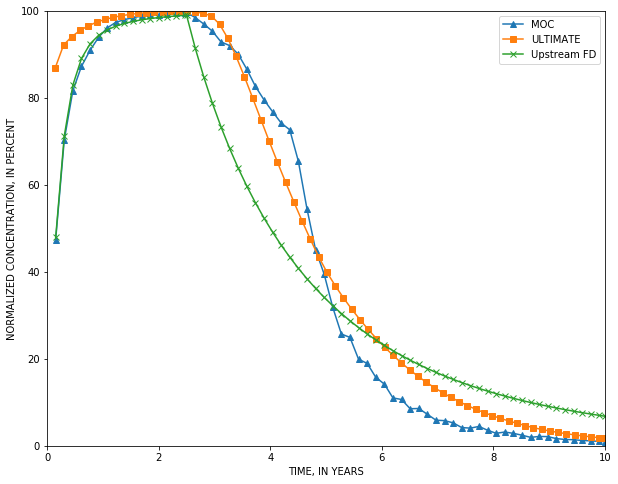

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
mf, mt, conc, cvt, mvt   = p06('p06', 1, 56.25)
x = cvt['time'] / 365.
y = cvt['(1, 16, 16)']
ax.plot(x, y, label='MOC', marker='^')

mf, mt, conc, cvt, mvt = p06('p06', -1, 56.25)
x = cvt['time'] / 365.
y = cvt['(1, 16, 16)']
ax.plot(x, y, label='ULTIMATE', marker='s')

mf, mt, conc, cvt, mvt = p06('p06', 0, 56.25)
x = cvt['time'] / 365.
y = cvt['(1, 16, 16)']
ax.plot(x, y, label='Upstream FD', marker='x')

plt.xlim(0, 10)
plt.ylim(0, 100.0)
plt.xlabel('TIME, IN YEARS')
plt.ylabel('NORMALIZED CONCENTRATION, IN PERCENT')
plt.legend()

## Example 7. Three-Dimensional Transport in a Uniform Flow Field

In [22]:
def p07(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 8
    nrow = 15
    ncol = 21
    delr = 10
    delc = 10
    delv = 10
    Lx = (ncol - 1) * delr
    v = 1. / 3.
    prsity = 0.2
    q = v * prsity
    al = 10.
    trpt = 0.3
    trpv = 0.3
    q0 = 0.5
    c0 = 100.

    perlen_mf = 100.
    perlen_mt = 100.
    hk = 0.5
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, 
                               exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., 
                                   botm=[-delv * k for k in range(1, nlay + 1)],
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[:, :, 0] = -1
    ibound[:, :, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    strt[:, :, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[6, 7, 2, q0]])
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv)
    spd = {0:[6, 7, 2, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

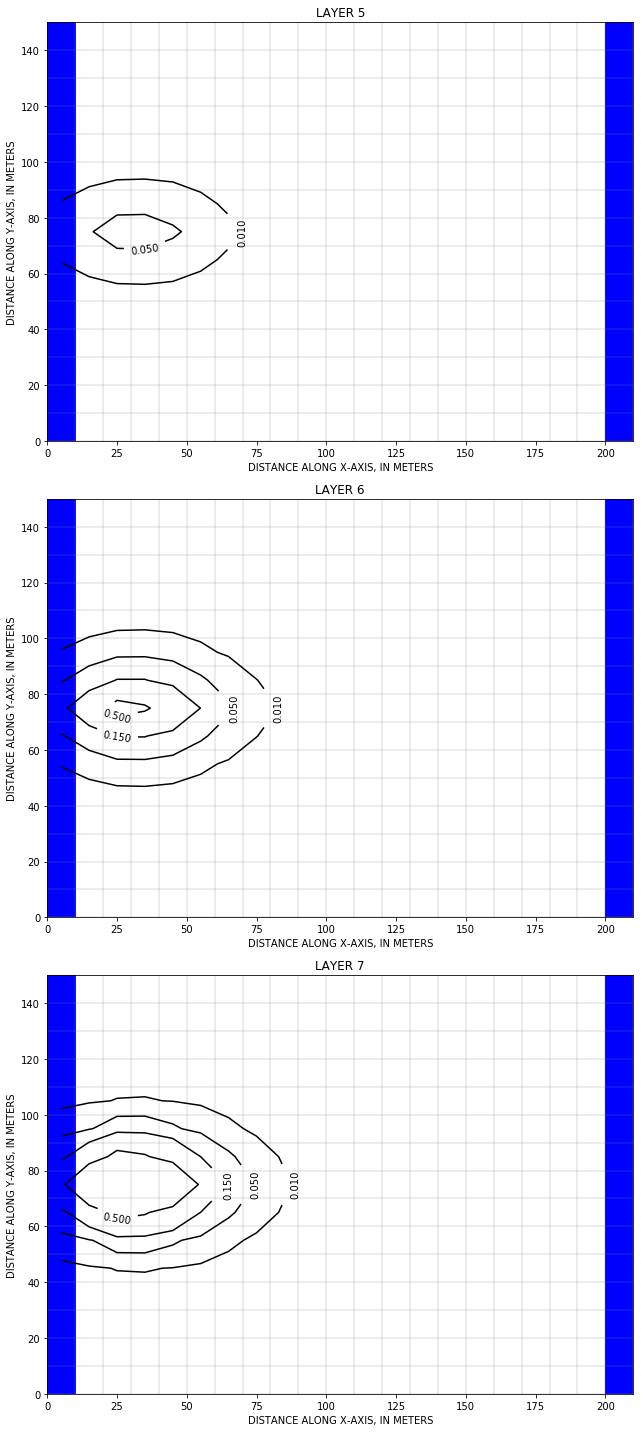

In [23]:
fig = plt.figure(figsize=(10, 20))
mf, mt, conc, cvt, mvt = p07('p07', -1)
conc = conc[0]

ax = fig.add_subplot(3, 1, 1, aspect='equal')
ilay = 4
mm = flopy.plot.ModelMap(ax=ax, model=mf, layer=ilay)
mm.plot_grid(color='.5', alpha=0.2)
mm.plot_ibound()
cs = mm.contour_array(conc, levels=[0.01, 0.05, 0.15, 0.50], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {}'.format(ilay + 1))

ax = fig.add_subplot(3, 1, 2, aspect='equal')
ilay = 5
mm = flopy.plot.ModelMap(ax=ax, model=mf, layer=ilay)
mm.plot_grid(color='.5', alpha=0.2)
mm.plot_ibound()
cs = mm.contour_array(conc, levels=[0.01, 0.05, 0.15, 0.50], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {}'.format(ilay + 1))

ax = fig.add_subplot(3, 1, 3, aspect='equal')
ilay = 6
mm = flopy.plot.ModelMap(ax=ax, model=mf, layer=ilay)
mm.plot_grid(color='.5', alpha=0.2)
mm.plot_ibound()
cs = mm.contour_array(conc, levels=[0.01, 0.05, 0.15, 0.50], colors='k')
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {}'.format(ilay + 1))
plt.plot(sr.xcentergrid[7, 2], sr.ycentergrid[7, 2], 'ko')

plt.tight_layout()

## Example 8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer

In [24]:
def p08(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 27
    nrow = 1
    ncol = 50
    delr = 5
    delc = 1
    delv = 0.25
    prsity = 0.35
    al = 0.5
    trpt = 0.01
    trpv = 0.01
    dmcoef = 1.34e-5 / 100 / 100 * 86400
    rech = 0.1 / 365 # m/d

    perlen_mf = 1
    perlen_mt = [5 * 365, 15 * 365]

    k1 = 5e-4 / 100. * 86400 # m/d
    k2 = 1e-2 / 100. * 86400 # m/d
    hk = k1 * np.ones((nlay, nrow, ncol), dtype=np.float)
    hk[11:19, :, 0:24] = k2
    hk[11:19, :, 36:] = k2
    laytyp = 6 * [1] + 21 * [0]

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, 
                               exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=6.75, 
                                   botm=[6.75 - delv * k for k in range(1, nlay + 1)],
                                   perlen=perlen_mf)
    f = open(os.path.join(datadir, 'p08shead.dat'))
    strt = np.empty((nlay * ncol), dtype=np.float)
    strt = read1d(f, strt).reshape((nlay, nrow, ncol))
    f.close()
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[5:, :, -1] = -1
    ibound[strt < 0] = 0

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=hk, laytyp=laytyp)
    rch = flopy.modflow.ModflowRch(mf, rech=rech)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0, nper=2,
                             perlen=perlen_mt, timprs=[8 * 365, 12 * 365, 20 * 365])
    percel = 1.0
    itrack = 3
    wd = 0.5
    dceps = 1.e-5
    nplane = 0
    npl = 0
    nph = 10
    npmin = 2
    npmax = 20
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=percel, 
                             itrack=itrack, wd=wd)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)
    crch1 = np.zeros((nrow, ncol), dtype=np.float)
    crch1[0, 9:18] = 1.
    cnc0 = [(0, 0, j, 1, -1) for j in range(8, 16)]
    cnc1 = [(0, 0, j, 0., -1) for j in range(8, 16)]
    ssmspd = {0: cnc0, 1:cnc1}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssmspd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

found 'rch' in modflow model, resetting crch to 0.0


Text(0.5,1,'TIME = 20 YEARS')

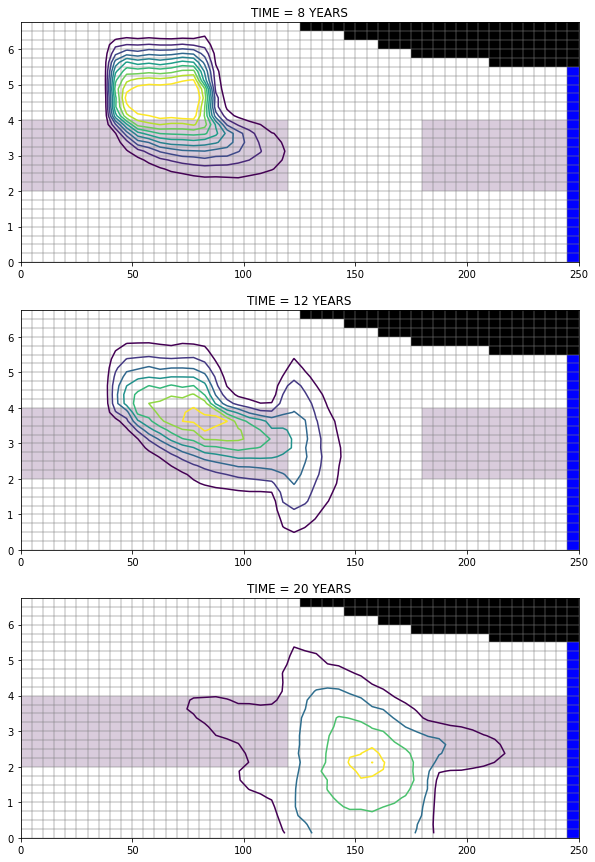

In [25]:
fig = plt.figure(figsize=(10, 15))
mf, mt, conc, cvt, mvt = p08('p08', 3)
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.ModelCrossSection(ax, model=mf, line={'row':0})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
mx.plot_ibound()
mx.plot_grid(color='0.5', alpha=0.2)
cs = mx.contour_array(conc[1], levels=np.arange(.05, .55, .05), masked_values=[1.e30])
ax.set_title('TIME = 8 YEARS')

ax = fig.add_subplot(3, 1, 2)
mx = flopy.plot.ModelCrossSection(ax, model=mf, line={'row':0})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
mx.plot_ibound()
mx.plot_grid(color='0.5', alpha=0.2)
cs = mx.contour_array(conc[2], levels=np.arange(.05, .55, .05), masked_values=[1.e30])
ax.set_title('TIME = 12 YEARS')

ax = fig.add_subplot(3, 1, 3)
mx = flopy.plot.ModelCrossSection(ax, model=mf, line={'row':0})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
mx.plot_ibound()
mx.plot_grid(color='0.5', alpha=0.2)
cs = mx.contour_array(conc[3], levels=[.05, .1, .15, .19], masked_values=[1.e30])
ax.set_title('TIME = 20 YEARS')

## Example 9. Two-Dimensional Application Example

In [26]:
def p09(dirname, mixelm, nadvfd):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 18
    ncol = 14
    delr = 100
    delc = 100
    delv = 10
    prsity = 0.3
    al = 20.
    trpt = 0.2

    perlen_mf = 1.
    perlen_mt = [365. * 86400, 365. * 86400]
    laytyp = 0
    k1 = 1.474e-4
    k2 = 1.474e-7
    hk = k1 * np.ones((nlay, nrow, ncol), dtype=np.float)
    hk[:, 5:8, 1:8] = k2

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[0, 0, :] = -1
    ibound[0, -1, :] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    strt[0, 0, :] = 250.
    xc = dis.sr.xcenter
    for j in range(ncol):
        strt[0, -1, j] = 20. + (xc[j] - xc[0]) * 2.5 / 100
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    welspd = [[0, 3, 6, 0.001], [0, 10, 6, -0.0189]]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0, 
                             nper=2, perlen=perlen_mt, obs=[[0, 10, 6]])
    percel = 1.
    itrack = 2
    dceps = 1.e-5
    nplane = 0
    npl = 0
    nph = 16
    npmin = 0
    npmax = 32
    dchmoc=1.e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=percel,
                             itrack=itrack, nadvfd=nadvfd)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0:[[0, 3, 6, 57.87, 2], [0, 10, 6, 0., 2]],
           1:[[0, 3, 6, 0., 2], [0, 10, 6, 0., 2]]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

Text(0.5,1,'ULTIMATE')

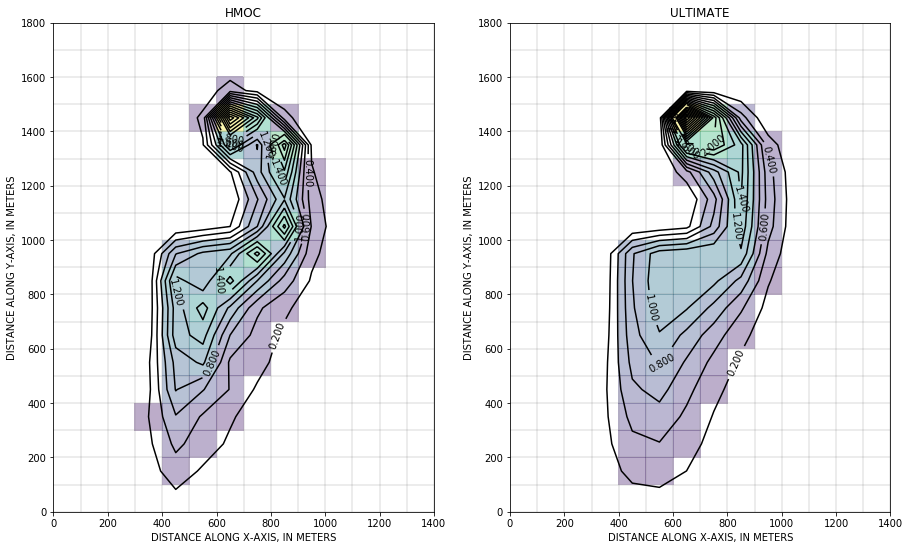

In [27]:
fig = plt.figure(figsize=(15, 10))
levels = np.arange(0.2, 10, .2)

ax = fig.add_subplot(1, 2, 1, aspect='equal')
mf, mt, conc, cvt, mvt = p09('p09', 3, 1)
cvt['time'] / 365. / 86400.
y = cvt['(1, 11, 7)']
conc = conc[:, 0, :, :]
cflood = np.ma.masked_less_equal(conc, 0.2)
mm = flopy.plot.ModelMap(ax=ax, model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.plot_array(cflood[0], alpha=0.2, vmin=0, vmax=3)
cs = mm.contour_array(conc[0], colors='k', levels=levels)
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('HMOC')

ax = fig.add_subplot(1, 2, 2, aspect='equal')
mf, mt, conc, cvt, mvt = p09('p09', -1, 1)
cvt['time'] / 365. / 86400.
y = cvt['(1, 11, 7)']
conc = conc[:, 0, :, :]
cflood = np.ma.masked_less_equal(conc, 0.2)
mm = flopy.plot.ModelMap(ax=ax, model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.plot_array(cflood[0], alpha=0.2, vmin=0, vmax=3)
cs = mm.contour_array(conc[0], colors='k', levels=levels)
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('ULTIMATE')

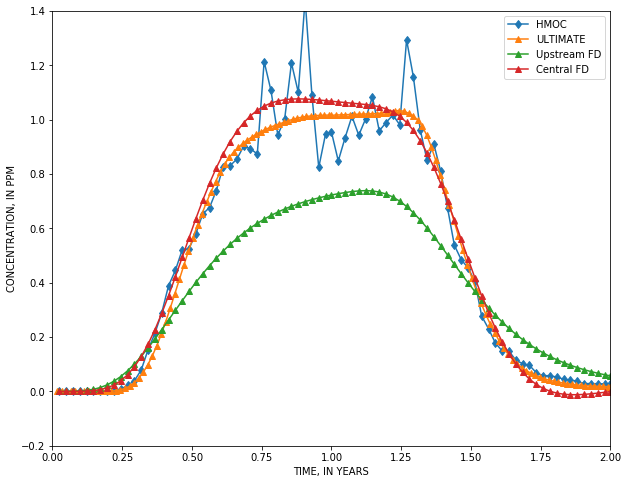

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

mf, mt, conc, cvt, mvt = p09('p09', 3, 1)
x = cvt['time'] / 365. / 86400.
y = cvt['(1, 11, 7)']
plt.plot(x, y, label='HMOC', marker='d')

mf, mt, conc, cvt, mvt = p09('p09', -1, 1)
x = cvt['time'] / 365. / 86400.
y = cvt['(1, 11, 7)']
plt.plot(x, y, label='ULTIMATE', marker='^')

mf, mt, conc, cvt, mvt = p09('p09', 0, 1)
x = cvt['time'] / 365. / 86400.
y = cvt['(1, 11, 7)']
plt.plot(x, y, label='Upstream FD', marker='^')

mf, mt, conc, cvt, mvt = p09('p09', 0, 2)
x = cvt['time'] / 365. / 86400.
y = cvt['(1, 11, 7)']
plt.plot(x, y, label='Central FD', marker='^')

plt.xlim(0, 2)
plt.ylim(-.2, 1.4)
plt.xlabel('TIME, IN YEARS')
plt.ylabel('CONCENTRATION, IN PPM')
plt.legend()

## Example 10. Three-Dimensional Field Case Study

In [29]:
def p10(dirname, mixelm, perlen=1000, isothm=1, sp2=0., ttsmult=1.2):
    model_ws = os.path.join(workdir, dirname)
    nlay = 4
    nrow = 61
    ncol = 40
    delr = [2000, 1600, 800, 400, 200, 100] + 28*[50] + [100, 200, 400, 800, 1600, 2000]
    delc = [2000, 2000, 2000, 1600, 800, 400, 200, 100] + 45 * [50] + [100, 200, 400, 800, 1600, 2000, 2000, 2000]
    delv = 25.
    top = 780.
    botm = [top - delv * k for k in range(1, nlay + 1)]
    prsity = 0.3
    al = 10.
    trpt = 0.2
    trpv = 0.2

    perlen_mf = perlen
    perlen_mt = perlen
    hk = [60., 60., 520., 520.]
    vka = .1
    laytyp = 0

    modelname_mf = dirname + '_mf'
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, 
                               exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol,
                                   delr=delr, delc=delc, top=top, 
                                   botm=botm,
                                   perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    ibound[:, :, 0] = -1
    ibound[:, :, -1] = -1

    f = open(os.path.join(datadir, 'p10shead.dat'))
    s0 = np.empty((nrow * ncol), dtype=np.float)
    s0 = read1d(f, s0).reshape((nrow, ncol))
    f.close()
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    for k in range(nlay):
        strt[k] = s0
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, layvka=1, vka=vka, laytyp=laytyp)
    welspd = [[3 - 1, 11 - 1, 29 - 1, -19230.00],
              [3 - 1, 19 - 1, 26 - 1, -19230.00],
              [3 - 1, 26 - 1, 23 - 1, -19230.00],
              [3 - 1, 33 - 1, 20 - 1, -19230.00],
              [3 - 1, 40 - 1, 17 - 1, -19230.00],
              [3 - 1, 48 - 1, 14 - 1, -19230.00],
              [3 - 1, 48 - 1,  9 - 1, -15384.00],
              [3 - 1, 52 - 1, 17 - 1, -17307.00]]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    rch = flopy.modflow.ModflowRch(mf, rech=1.14e-3)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mf.run_model(silent=True)

    modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)
    f = open(os.path.join(datadir, 'p10cinit.dat'))
    c0 = np.empty((nrow * ncol), dtype=np.float)
    c0 = read1d(f, c0).reshape((nrow, ncol))
    f.close()
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    sconc[1] = 0.2 * c0
    sconc[2] = c0
    obs = [[3 - 1, 11 - 1, 29 - 1],
           [3 - 1, 19 - 1, 26 - 1],
           [3 - 1, 26 - 1, 23 - 1],
           [3 - 1, 33 - 1, 20 - 1],
           [3 - 1, 40 - 1, 17 - 1],
           [3 - 1, 48 - 1, 14 - 1],
           [3 - 1, 48 - 1,  9 - 1],
           [3 - 1, 52 - 1, 17 - 1]]    
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=sconc,
                             timprs=[500, 750, 1000], dt0=2.25, ttsmult=ttsmult, 
                             obs=obs)
    dceps = 1.e-5
    nplane = 0
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc = 0.01
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=1.0)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv)
    ssm = flopy.mt3d.Mt3dSsm(mt, crch=0.)
    rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, igetsc=0, rhob=1.7, 
                             sp1=0.176, sp2=sp2)
    mxiter = 1
    if isothm == 4:
        mxiter = 50
    gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=500)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, 'MT3D001.OBS')
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, 'MT3D001.MAS')
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt
    #return mf, mt, conc[:, :, :, :], cvt, mvt

In [30]:
mf, mt, conctvd, cvttvd, mvttvd = p10('p10', -1)
mf, mt, conchmoc, cvthmoc, mvthmoc = p10('p10', 3)
mf, mt, concupfd, cvtupfd, mvtupfd = p10('p10', 0, ttsmult=1.0)
sr = mf.dis.sr

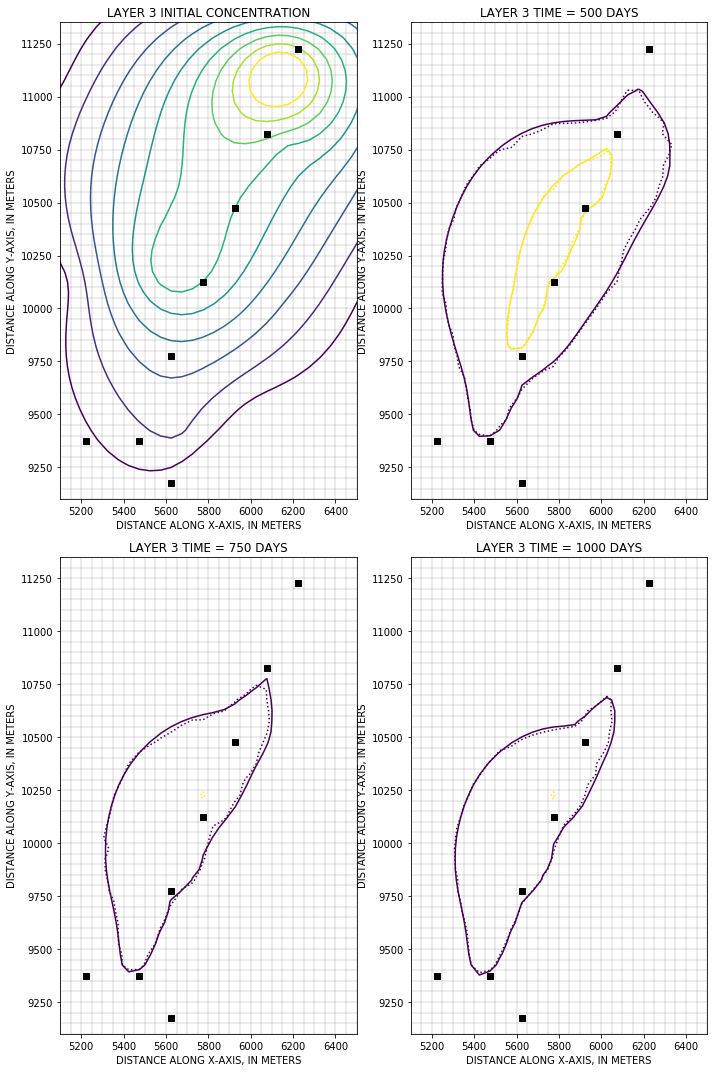

In [31]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(2, 2, 1, aspect='equal')
cinit = mt.btn.sconc[0].array[2]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(cinit, levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {} INITIAL CONCENTRATION'.format(3))
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(sr.xcenter[j], sr.ycenter[i], 'ks')

ax = fig.add_subplot(2, 2, 2, aspect='equal')
c = conctvd[0, 2]
chmoc = conchmoc[0, 2]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(c, levels=np.arange(20, 200, 20))
cs = mm.contour_array(chmoc, linestyles=':', levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {} TIME = 500 DAYS'.format(3))
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(sr.xcenter[j], sr.ycenter[i], 'ks')

ax = fig.add_subplot(2, 2, 3, aspect='equal')
c = conctvd[1, 2]
chmoc = conchmoc[1, 2]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(c, levels=np.arange(20, 200, 20))
cs = mm.contour_array(chmoc, linestyles=':', levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {} TIME = 750 DAYS'.format(3))
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(sr.xcenter[j], sr.ycenter[i], 'ks')

ax = fig.add_subplot(2, 2, 4, aspect='equal')
c = conctvd[1, 3]
chmoc = conchmoc[1, 3]
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
cs = mm.contour_array(c, levels=np.arange(20, 200, 20))
cs = mm.contour_array(chmoc, linestyles=':', levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('LAYER {} TIME = 1000 DAYS'.format(3))
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(sr.xcenter[j], sr.ycenter[i], 'ks')

plt.tight_layout()

Text(0,0.5,'CONCENTRATION, IN PPB')

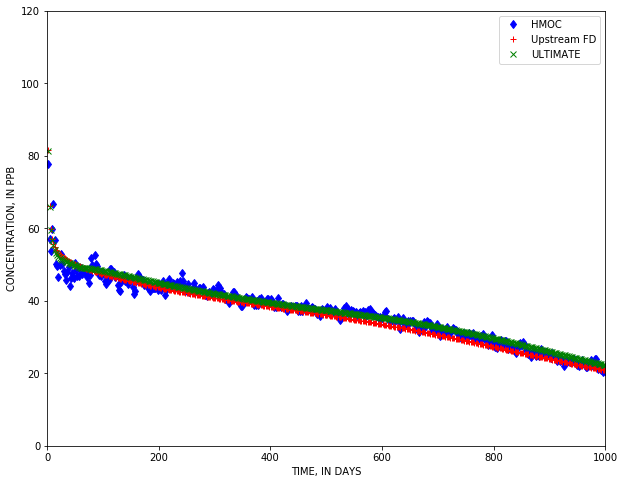

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
w4 = '(3, 33, 20)'
ax.plot(cvthmoc['time'], cvthmoc[w4], 'bd', label='HMOC')
ax.plot(cvtupfd['time'], cvtupfd[w4], 'r+', label='Upstream FD')
ax.plot(cvttvd['time'], cvttvd[w4], 'gx', label='ULTIMATE')
plt.xlim(0, 1000)
plt.ylim(0, 120)
plt.legend()
plt.xlabel('TIME, IN DAYS')
plt.ylabel('CONCENTRATION, IN PPB')

In [33]:
mf, mt, conctvd, cvttvd, mvt0 = p10('p10', 0, perlen=2000, isothm=0)
mf, mt, conctvd, cvttvd, mvt1 = p10('p10', 0, perlen=2000, isothm=1)
mf, mt, conctvd, cvttvd, mvt2 = p10('p10', 0, perlen=2000, isothm=4, sp2=0.1)
mf, mt, conctvd, cvttvd, mvt3 = p10('p10', 0, perlen=2000, isothm=4, sp2=1.5e-4)
mf, mt, conctvd, cvttvd, mvt4 = p10('p10', 0, perlen=2000, isothm=4, sp2=1.e-6)

Text(0,0.5,'TOTAL MASS REMOVED')

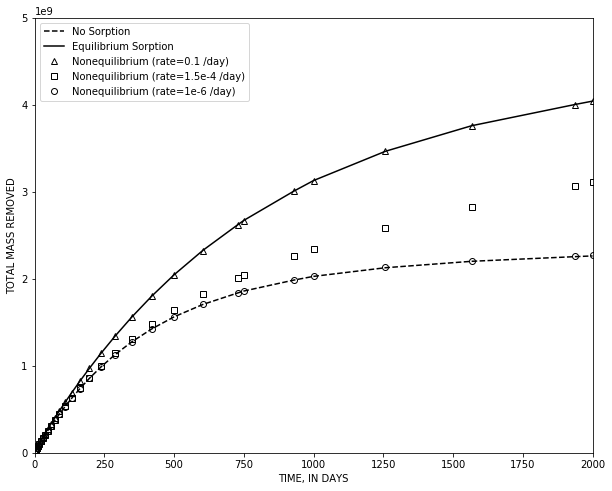

In [34]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(mvt0['time'], -mvt0['sinks'], 'k--', label='No Sorption')
ax.plot(mvt1['time'], -mvt1['sinks'], 'k-', label='Equilibrium Sorption')
ax.plot(mvt2['time'], -mvt2['sinks'], 'k^', fillstyle='none', 
        label='Nonequilibrium (rate=0.1 /day)')
ax.plot(mvt3['time'], -mvt3['sinks'], 'ks', fillstyle='none', 
        label='Nonequilibrium (rate=1.5e-4 /day)')
ax.plot(mvt4['time'], -mvt4['sinks'], 'ko', fillstyle='none', 
        label='Nonequilibrium (rate=1e-6 /day)')
plt.xlim(0, 2000)
plt.ylim(0, 5e9)
plt.legend(loc=2)
plt.xlabel('TIME, IN DAYS')
plt.ylabel('TOTAL MASS REMOVED')